In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from torch.optim import AdamW

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import gc

import sys
sys.path.append("../src")
import FE
import dataset
import models
import util
from config import read_config, updateConfig
import train_helper
import infer_helper
import loss
import lrfinder

In [3]:
print(torch.version.cuda)

11.1


# Config

In [4]:
BaseConfig = read_config("base")
{key: val for key, val in BaseConfig.__dict__.items() if not key.startswith('__')}

{'kaggle_data_folder': '/home/vincent/Kaggle/data/ventilator-pressure-prediction',
 'input_folder': '../input/',
 'output_folder': '../output/',
 'debug': False,
 'model_version': 'BasicTest',
 'model_module': 'Fork',
 'PL_folder': None,
 'seed': 48,
 'ckpt_folder': None,
 'use_lr_finder': False,
 'low_q': 0.05,
 'high_q': 0.95,
 'unit_var': True,
 'strict_scale': True,
 'hidden': [512, 256, 128, 64],
 'bidirectional': True,
 'nh': 256,
 'do_prob': 0.1,
 'epochs': 20,
 'es': 10,
 'train_folds': [0],
 'batch_size': 1024,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'warmup': 0.1,
 'scheduler': 'cosineWithWarmUp',
 'use_swa': False,
 'use_wandb': False,
 'wandb_project': 'GBVPP',
 'wandb_key_path': '../input/key.txt',
 'wandb_post': '',
 'print_num_steps': 100,
 'num_workers': 8,
 'use_dp': True}

In [5]:
class config(BaseConfig):
    model_version = "testSpeed"
    debug=False
    epochs = 10
    batch_size = 512
    lr=5e-2
    train_folds = [0]
    use_wandb = False
    use_lr_finder = True
config = updateConfig(config)

Using device: cuda
Number of device: 2
Model Output Folder: ../output/testSpeed/


In [6]:
print(torch.cuda.is_available())

True


In [7]:
train, test = dataset.read_data(config)
display(train.shape, test.shape)
display(train.head())
display(test.head())

(6036000, 9)

(4024000, 7)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold
0,1,1,20,50,0.000000,0.083334,0,5.837492,0
1,2,1,20,50,0.033652,18.383041,0,5.907794,4
2,3,1,20,50,0.067514,22.509277,0,7.876254,2
3,4,1,20,50,0.101542,22.808823,0,11.742872,0
4,5,1,20,50,0.135756,25.355850,0,12.234987,2


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320955,0


# adding features

In [8]:
train = FE.add_features(train)
test = FE.add_features(test)

In [9]:
feature_cols = [col for col in train.columns if col not in ["id", "breath_id", "fold", "pressure"]]
print(feature_cols)

['time_step', 'u_in', 'u_out', 'step', 'area', 'u_in_cumsum', 'time_step_diff', 'cross_time', 'cross_u_in', 'u_in_diff', 'u_in_diff_2', 'u_in_diff_5', 'ewm_u_in_mean', 'ewm_u_in_std', 'ewm_u_in_corr', 'rolling_10_mean', 'rolling_10_max', 'rolling_10_std', 'expand_mean', 'expand_median', 'expand_std', 'expand_max', 'expand_skew', 'expand_kurt', 'RC_u_in_median_diff', 'RC_u_in_mean_diff', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20', 'C_50']


In [10]:
display(train.head()), display(test.head())

,id,breath_id,time_step,u_in,u_out,pressure,fold,step,area,u_in_cumsum,...,expand_skew,expand_kurt,RC_u_in_median_diff,RC_u_in_mean_diff,R_20,R_5,R_50,C_10,C_20,C_50
0,1,1,0.000000,0.083334,0,5.837492,0,0,0.000000,0.083334,...,0.000000,0.000000,-1.097566,-16.472822,1,0,0,0,0,1
1,2,1,0.033652,18.383041,0,5.907794,4,1,0.618632,18.466375,...,0.000000,0.000000,10.217401,-6.304752,1,0,0,0,0,1
2,3,1,0.067514,22.509277,0,7.876254,2,2,2.138332,40.975655,...,0.000000,0.000000,11.105179,1.167955,1,0,0,0,0,1
3,4,1,0.101542,22.808823,0,11.742872,0,3,4.454391,63.784477,...,3.227848,3.227848,11.056578,6.697302,1,0,0,0,0,1
4,5,1,0.135756,25.355850,0,12.234987,2,4,7.896588,89.140327,...,3.809552,3.809552,8.360462,2.357504,1,0,0,0,0,1


,id,breath_id,time_step,u_in,u_out,step,area,u_in_cumsum,time_step_diff,cross_time,...,expand_skew,expand_kurt,RC_u_in_median_diff,RC_u_in_mean_diff,R_20,R_5,R_50,C_10,C_20,C_50
0,1,0,0.000000,0.000000,0,0,0.000000,0.000000,0.033430,0.000000,...,0.000000,0.000000,-5.150383,-16.782158,0,1,0,0,1,0
1,2,0,0.031904,7.515046,0,1,0.239758,7.515046,0.031904,0.031904,...,0.000000,0.000000,-12.216171,-23.216238,0,1,0,0,1,0
2,3,0,0.063827,14.651675,0,2,1.174935,22.166721,0.031924,0.063827,...,0.000000,0.000000,-6.876708,-15.921069,0,1,0,0,1,0
3,4,0,0.095751,21.230610,0,3,3.207788,43.397331,0.031924,0.095751,...,-1.218656,-1.218656,-1.844667,-8.482742,0,1,0,0,1,0
4,5,0,0.127644,26.320955,0,4,6.567489,69.718285,0.031893,0.127644,...,-1.280772,-1.280772,2.122213,-3.948595,0,1,0,0,1,0


(None, None)

# Learning Rate Finder

In [23]:
if config.use_lr_finder:
    # data
    rs = RobustScaler(quantile_range=(config.low_q, config.high_q), unit_variance=config.unit_var)
    X_train = rs.fit_transform(train[feature_cols])
    X_train = X_train.reshape(-1, 80, len(feature_cols))
    y_train = train['pressure'].values.reshape(-1, 80)
    w_train = (1 - train['u_out']).values.reshape(-1, 80)
    train_dt = dataset.LR_VPP(X_train, y_train, w_train, config.batch_size)
    train_loader = DataLoader(train_dt,
                              batch_size=config.batch_size,
                              shuffle=True,
                              num_workers=config.num_workers, pin_memory=True, drop_last=False)

In [24]:
if config.use_lr_finder:
    # model
    model = models.Model(len(feature_cols),config)
    model.to(config.device)
    if config.use_dp:
        model = DataParallel(model)
    optimizer = AdamW(model.parameters(), lr=1e-6, eps=1e-08, weight_decay=config.weight_decay, amsgrad=False)
    criterion = loss.cal_mae_loss

In [25]:
if config.use_lr_finder:
    lr_finder = lrfinder.LRFinder(model, optimizer, criterion, config.device)
    lrs, losses = lr_finder.range_test(train_loader, end_lr=10, num_iter=100, smooth_f=0.05, diverge_th=5)    

/home/vincent/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:679: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:924.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


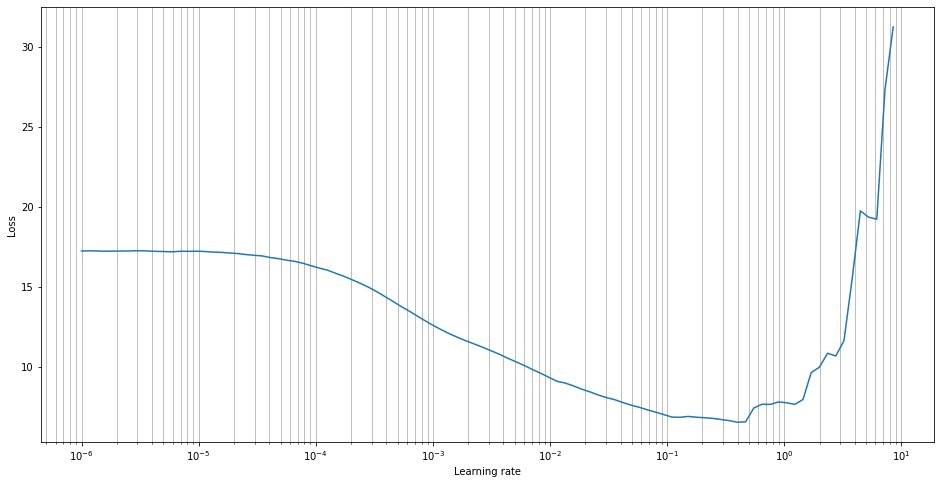

In [26]:
lrfinder.plot_lr_finder(lrs, losses)

In [27]:
del model, optimizer, criterion, train_dt, train_loader, lr_finder
gc.collect()
torch.cuda.empty_cache() 

# Training

In [17]:
train_helper.training_loop(train.copy(), config)

Fold:  0
Prepare train valid
(4828800, 9) (1207200, 9)
(4828800, 22)
training data samples, val data samples:  (60360, 80, 22) (15090, 80, 22)
Model Size: 5696501
Epoch:  0


/media/vincentwang/Backup/GBVPP/notebook/../src/train_helper.py:195: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
/home/vincentwang/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `opti

[100/236]  avg loss:  4.455181884765625 inst loss:  2.150235414505005
[200/236]  avg loss:  3.2499423217773438 inst loss:  1.8562780618667603
Save Model
loss:  3.0331, val_loss 5.0138, val_score 5.0139, best_val_score 5.0139
time used:  489.2443506717682
Epoch:  1


KeyboardInterrupt: 

In [10]:
gc.collect()
torch.cuda.empty_cache()

# Inference

In [11]:
test_avg = infer_helper.get_test_avg(train, test, config)

Prepare train valid
(6036000, 9) (4024000, 8)
(6036000, 22)


100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.13s/it]


count    4.024000e+06
mean     9.988471e-01
std      1.597380e-03
min      9.459643e-01
25%      9.982858e-01
50%      9.991580e-01
75%      9.999946e-01
max      1.000000e+00
Name: pressure, dtype: float64
test file saved to: ../output/test25-75//submission.csv
